In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tqdm import tqdm

# Path to dataset and labels
data_path = './ASVspoof2017_V2_train/'
train_labels_file = 'ASVspoof2017_V2_train.trn.txt'

# Read labels
df = pd.read_csv(train_labels_file, sep=' ', header=None)
df.columns = ['file', 'label', 'speaker', 'sentence', 'ignore1', 'ignore2', 'ignore3']

In [2]:
# Load audio and extract features
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

In [5]:
import numpy as np  
X=np.load("featues_df_svc.npy")
y=np.load("labels_df_svc.npy")

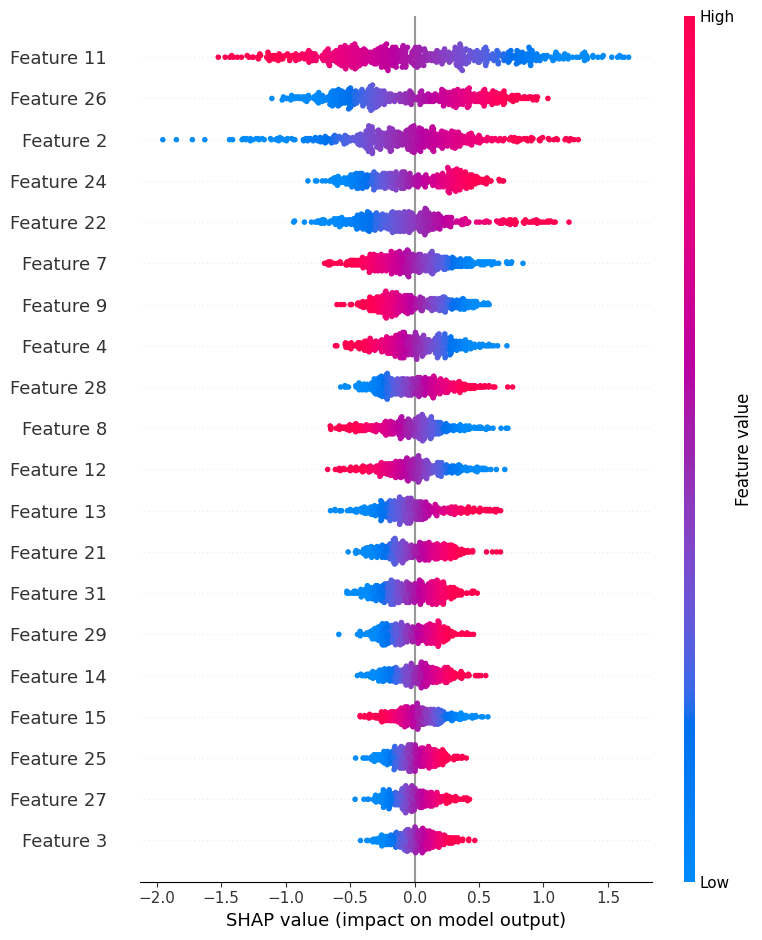

In [17]:
import shap
from sklearn.svm import SVC

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming you have your SVC model and data
model = SVC(kernel='linear')
model.fit(X_train, y_train)

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Plot the SHAP values
shap.summary_plot(shap_values, X_test)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       321
           1       1.00      0.99      1.00       282

    accuracy                           1.00       603
   macro avg       1.00      1.00      1.00       603
weighted avg       1.00      1.00      1.00       603



EER: 1.25% at threshold: 0.05240134955083157


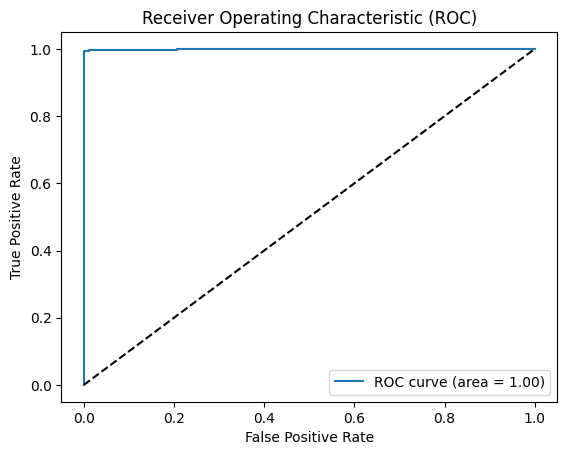

In [5]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test set
y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class ('spoof')

# Compute the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# Calculate False Rejection Rate (FRR)
fnr = 1 - tpr  # False Negative Rate (1 - TPR)

# Find the threshold where FAR equals FRR (Equal Error Rate)
eer_threshold = thresholds[np.nanargmin(np.absolute((fpr - fnr)))]
eer = fpr[np.nanargmin(np.absolute((fpr - fnr)))]

print(f'EER: {eer * 100:.2f}% at threshold: {eer_threshold}')

# Optional: Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [13]:
def get_feature_importance(model, X):
    return np.abs(model.coef_[0])

def plot_feature_importance(importance, feature_names):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importance)), importance)
    plt.xticks(range(len(importance)), feature_names, rotation=45)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance for Audio Deepfake Detection')
    plt.tight_layout()
    plt.show()

def explain_prediction(model, features, feature_names):
    # features = extract_features(audio)
    prediction = model.predict([features])[0]
    probabilities = model.predict_proba([features])[0]
    feature_importance = get_feature_importance(model, [features])
    
    print(f"Prediction: {'Fake' if prediction == 1 else 'Real'}")
    print(f"Confidence: {max(probabilities):.2f}")
    print("\nFeature contributions:")
    for name, importance in zip(feature_names, feature_importance):
        print(f"{name}: {importance:.4f}")


    plot_feature_importance(feature_importance, feature_names)

Prediction: Real
Confidence: 1.00

Feature contributions:
MFCC_0: 0.0016
MFCC_1: 0.0014
MFCC_2: 0.0258
MFCC_3: 0.0085
MFCC_4: 0.0119
MFCC_5: 0.0070
MFCC_6: 0.0055
MFCC_7: 0.0274
MFCC_8: 0.0320
MFCC_9: 0.0251
MFCC_10: 0.0169
MFCC_11: 0.0665
MFCC_12: 0.0377
MFCC_13: 0.0306
MFCC_14: 0.0244
MFCC_15: 0.0290
MFCC_16: 0.0075
MFCC_17: 0.0292
MFCC_18: 0.0348
MFCC_19: 0.0024
MFCC_20: 0.0055
MFCC_21: 0.0513
MFCC_22: 0.0639
MFCC_23: 0.0417
MFCC_24: 0.0643
MFCC_25: 0.0476
MFCC_26: 0.1038
MFCC_27: 0.0497
MFCC_28: 0.0638
MFCC_29: 0.0469
MFCC_30: 0.0042
MFCC_31: 0.0608
MFCC_32: 0.0121
MFCC_33: 0.0308
MFCC_34: 0.0253
MFCC_35: 0.0141
MFCC_36: 0.0139
MFCC_37: 0.0045
MFCC_38: 0.0166
MFCC_39: 0.0434


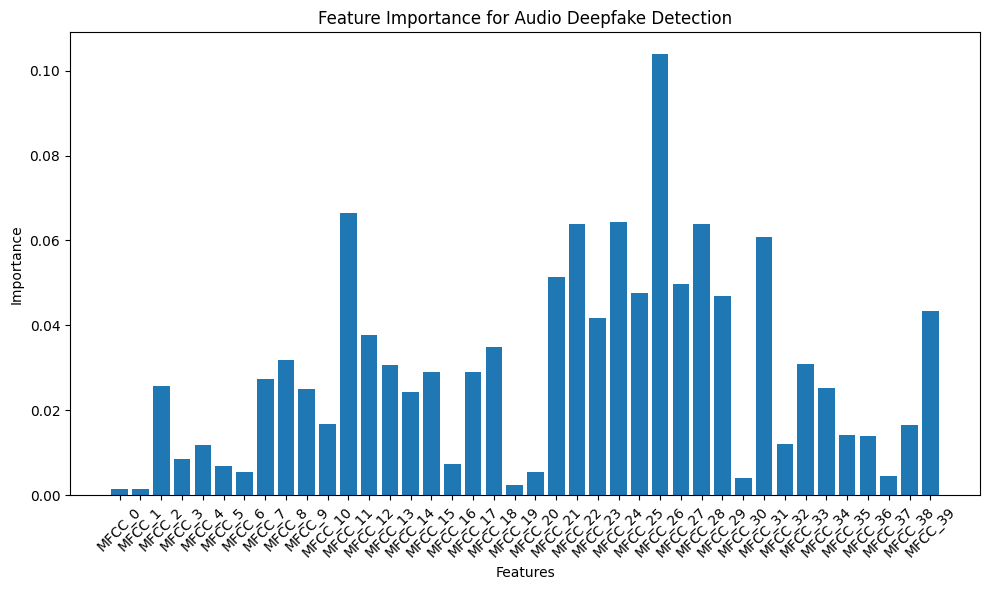

In [14]:
feature_names = [f"MFCC_{i}" for i in range(40)]
explain_prediction(model, X_test[5], feature_names)

In [31]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=['real', 'fake'], discretize_continuous=True)

i = 0  # Index of the instance to explain
exp = explainer.explain_instance(X_test[i], model.predict_proba, num_features=40)
exp.show_in_notebook(show_table=True)


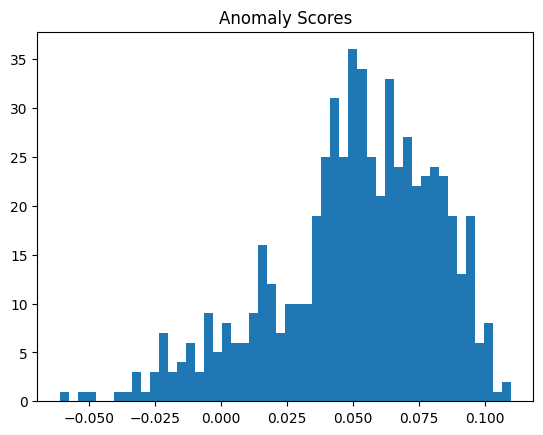

In [32]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1)
iso_forest.fit(X_train)

anomaly_scores = iso_forest.decision_function(X_test)

plt.hist(anomaly_scores, bins=50)
plt.title('Anomaly Scores')
plt.show()

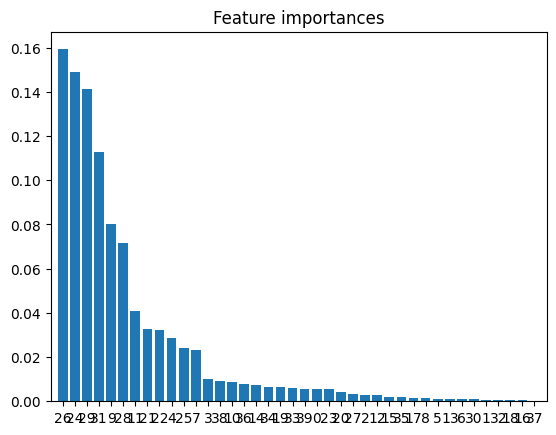

In [35]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Assuming you have a trained deep learning model
class AudioModel(torch.nn.Module):
    def __init__(self):
        super(AudioModel, self).__init__()
        # Define your model architecture here

    def forward(self, x):
        # Define the forward pass here
        return x

model = AudioModel()
model.load_state_dict(torch.load('model.pth'))
model.eval()

# Function to compute Grad-CAM
def compute_grad_cam(model, input_tensor, target_class):
    # Register hook to get the gradients of the target layer
    def hook_fn(module, grad_in, grad_out):
        grad_cam.append(grad_out[0].detach())

    grad_cam = []
    hook = model.layer.register_backward_hook(hook_fn)

    # Forward pass
    output = model(input_tensor)
    target = output[0, target_class]

    # Backward pass
    model.zero_grad()
    target.backward(retain_graph=True)

    # Get pooled gradients
    pooled_gradients = torch.mean(grad_cam[0], dim=[0, 2, 3])

    # Get activations of the target layer
    activations = model.layer(input_tensor).detach()

    # Weight the channels by the importance of each channel
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)

    # Convert heatmap to RGB
    heatmap = cv2.resize(heatmap.numpy(), (input_tensor.shape[3], input_tensor.shape[2]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    return heatmap

# Load audio and convert to spectrogram
def load_audio_as_spectrogram(file_name):
    y, sr = librosa.load(file_name)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram

input_tensor = load_audio_as_spectrogram('audio_file.wav')
input_tensor = torch.tensor(input_tensor).unsqueeze(0).unsqueeze(0)

# Compute Grad-CAM
heatmap = compute_grad_cam(model, input_tensor, target_class=1)

# Plot the heatmap
plt.imshow(heatmap)
plt.axis('off')
plt.show()

In [26]:
data_path = './ '
train_labels_file = 'ASVspoof2017_V2_eval.trl.txt'


# Read labels
df = pd.read_csv(train_labels_file, sep=' ', header=None)
df.columns = ['file', 'label', 'speaker', 'sentence', 'ignore1', 'ignore2', 'ignore3']

# Load audio and extract features
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

# Initialize progress bar
tqdm.pandas(desc="Extracting features")

# Apply feature extraction with progress bar
df['features'] = df['file'].progress_apply(lambda x: extract_features(os.path.join(data_path, x)))
# Prepare data
X = np.array(df['features'].tolist())
y = np.where(df['label'] == 'genuine', 0, 1)  # 0 for genuine, 1 for spoof
np.save("featues_df_svc_eval_data",X)
np.save("labels_df_svc_eval_data",y)

Extracting features: 100%|██████████| 13306/13306 [05:24<00:00, 40.98it/s]


In [2]:
testdata=np.load("featues_df_svc_eval_data.npy")
testdata_lab=np.load("labels_df_svc_eval_data.npy")

In [29]:
y_pred = model.predict(testdata)
print(classification_report(testdata_lab, y_pred))

              precision    recall  f1-score   support

           0       0.10      1.00      0.19      1298
           1       1.00      0.08      0.14     12008

    accuracy                           0.17     13306
   macro avg       0.55      0.54      0.17     13306
weighted avg       0.91      0.17      0.15     13306



## DL (Testing / Kindly Ignore )

In [61]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Path to dataset and labels
data_path = './ASVspoof2017_V2_train'
train_labels_file = 'ASVspoof2017_V2_train.trn.txt'

# Read labels
df = pd.read_csv(train_labels_file, sep=' ', header=None)
df.columns = ['file', 'label', 'speaker', 'sentence', 'ignore1', 'ignore2', 'ignore3']

def pad_or_truncate_spectrogram(spectrogram, target_length=170):
    current_length = spectrogram.shape[1]
    if current_length > target_length:
        # Truncate
        spectrogram = spectrogram[:, :target_length, :]
    elif current_length < target_length:
        # Pad
        padding = target_length - current_length
        spectrogram = np.pad(spectrogram, ((0, 0), (0, padding), (0, 0)), mode='constant')
    return spectrogram

def extract_mel_spectrogram(file_name, target_length=170):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mel_spect = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    mel_spect = mel_spect[..., np.newaxis]  # Add a channel dimension for CNN
    mel_spect = pad_or_truncate_spectrogram(mel_spect, target_length)
    return mel_spect

# Initialize progress bar
tqdm.pandas(desc="Extracting Mel Spectrograms")

# Apply feature extraction with progress bar
df['features'] = df['file'].progress_apply(lambda x: extract_mel_spectrogram(os.path.join(data_path, x)))

# Prepare data
X = np.array(df['features'].tolist())
y = np.where(df['label'] == 'genuine', 0, 1)  # 0 for genuine, 1 for spoof

#saving the data
np.save("featues_df_dl",X)
np.save("labels_df_dl",y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

# Check the shape of the data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Extracting Mel Spectrograms: 100%|██████████| 3014/3014 [00:53<00:00, 56.69it/s]


Training data shape: (2411, 128, 170, 1)
Testing data shape: (603, 128, 170, 1)


In [62]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 168, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 84, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 82, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 41, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 39, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 19, 128)      0

Epoch 1/20
61/61 [==============================] - 7s 29ms/step - loss: 1116958.3750 - accuracy: 0.5280 - val_loss: 0.7089 - val_accuracy: 0.5259
Epoch 2/20
61/61 [==============================] - 1s 24ms/step - loss: 0.6862 - accuracy: 0.5716 - val_loss: 0.7052 - val_accuracy: 0.5135
Epoch 3/20
61/61 [==============================] - 1s 22ms/step - loss: 1.0496 - accuracy: 0.5825 - val_loss: 0.6962 - val_accuracy: 0.4990
Epoch 4/20
61/61 [==============================] - 1s 22ms/step - loss: 0.6772 - accuracy: 0.5840 - val_loss: 0.6990 - val_accuracy: 0.5093
Epoch 5/20
61/61 [==============================] - 1s 23ms/step - loss: 0.6743 - accuracy: 0.5783 - val_loss: 0.7018 - val_accuracy: 0.5072
Epoch 6/20
61/61 [==============================] - 1s 23ms/step - loss: 0.6717 - accuracy: 0.5835 - val_loss: 0.6974 - val_accuracy: 0.5176
Epoch 7/20
61/61 [==============================] - 1s 23ms/step - loss: 0.6671 - accuracy: 0.5877 - val_loss: 0.7005 - val_accuracy: 0.5114
Epoch 8

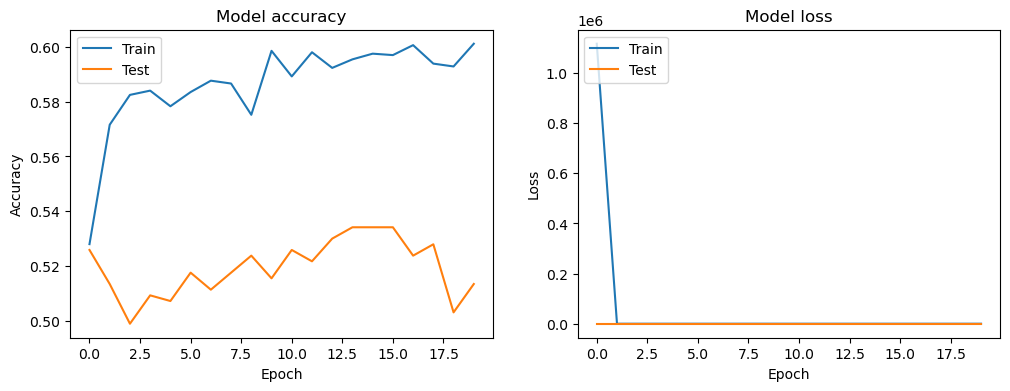

In [63]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [64]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

19/19 [==============================] - 1s 23ms/step - loss: 0.6811 - accuracy: 0.5589
Test accuracy: 0.5589


In [94]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Path to dataset and labels
data_path = './ASVspoof2017_V2_eval'
train_labels_file = 'ASVspoof2017_V2_eval.trl.txt'

# Read labels
df = pd.read_csv(train_labels_file, sep=' ', header=None)
df.columns = ['file', 'label', 'speaker', 'sentence', 'ignore1', 'ignore2', 'ignore3']

def pad_or_truncate_spectrogram(spectrogram, target_length=170):
    current_length = spectrogram.shape[1]
    if current_length > target_length:
        # Truncate
        spectrogram = spectrogram[:, :target_length, :]
    elif current_length < target_length:
        # Pad
        padding = target_length - current_length
        spectrogram = np.pad(spectrogram, ((0, 0), (0, padding), (0, 0)), mode='constant')
    return spectrogram

def extract_mel_spectrogram(file_name, target_length=170):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mel_spect = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    mel_spect = mel_spect[..., np.newaxis]  # Add a channel dimension for CNN
    mel_spect = pad_or_truncate_spectrogram(mel_spect, target_length)
    return mel_spect

# Initialize progress bar
tqdm.pandas(desc="Extracting Mel Spectrograms")

# Apply feature extraction with progress bar
df['features'] = df['file'].progress_apply(lambda x: extract_mel_spectrogram(os.path.join(data_path, x)))

# Prepare data
X = np.array(df['features'].tolist())
y = np.where(df['label'] == 'genuine', 0, 1)  # 0 for genuine, 1 for spoof

#saving the data
np.save(f"featues_{data_path[2:]}",X)
np.save(f"labels_{data_path[2:]}",y)

Extracting Mel Spectrograms: 100%|██████████| 13306/13306 [07:46<00:00, 28.54it/s]


In [95]:
# Normalize data
X = X / np.max(X)

# Check the shape of the data
print(f"Testing data shape: {X.shape}")

Testing data shape: (13306, 128, 170, 1)


19/19 [==============================] - 1s 29ms/step


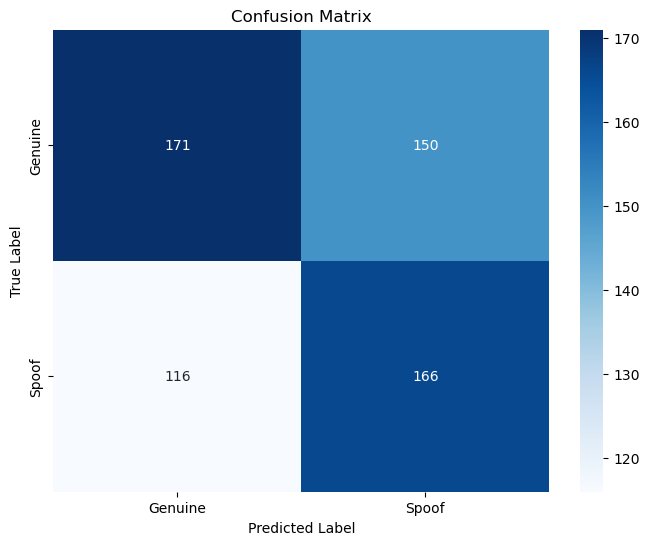

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have a trained model and X_test, y_test
y_pred_prob = model.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Spoof'], yticklabels=['Genuine', 'Spoof'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# def predict(file_path):
#     mel_spect = extract_mel_spectrogram(file_path)
#     mel_spect = mel_spect[np.newaxis, ...]  # Add batch dimension
#     prediction = model.predict(mel_spect)
#     return 'genuine' if prediction < 0.5 else 'spoof'

# # Example:
# for i in range(1000001,1003017):
#     new_file_path = './ASVspoof2017_V2_train/T_'+str(i)+'.wav'
#     print(predict(new_file_path))

In [31]:
X_test.shape

(603, 40)

In [32]:
X.shape

(13306, 40)

In [23]:
# Predict and evaluate
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.10      1.00      0.19      1298
           1       1.00      0.08      0.14     12008

    accuracy                           0.17     13306
   macro avg       0.55      0.54      0.17     13306
weighted avg       0.91      0.17      0.15     13306

